In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import os
import sys

sys.path.append('/Users/fllorente/Dropbox/con_Petar/PYTHON/gp_fusion')


import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, lax
from jax.scipy.linalg import cho_factor, cho_solve
import optax

from modules.data_handling import load_data  # Same as using Dataset but X and Y have std dv = 1 column-wise
from modules.fusion_methods import compute_neg_log_like

import numpy as np

import matplotlib.pyplot as plt

In [124]:
# Example function with a dynamic slice
def example_function(x, start, length):
    # This will fail because `start` and `length` are dynamic
    slice_result = lax.dynamic_slice(x, (start,), (length,))
    # slice_result = x[start:length]
    return slice_result

# Create a sample array
x = jnp.array([1, 2, 3, 4, 5])

# Call the function with dynamic slicing
print(example_function(x, 1, 3))  # Output: [2, 3, 4]

# JIT compilation will fail with dynamic sizes
try:
    jit_example_function = jit(example_function, 
                               static_argnames=["start","length"],
                               )
    print(jit_example_function(x, 1, 3))
except Exception as e:
    print("Error during JIT compilation:", e)

[2 3 4]
[2 3 4]


## Joint learning without projections

In [125]:

# RBF Kernel function with length_scale as a vector
def rbf_kernel(x1, x2, length_scale, variance):
    sqdist = jnp.sum(((x1 - x2) / length_scale) ** 2)
    return variance * jnp.exp(-0.5 * sqdist)

# Efficient kernel matrix computation using vmap
def kernel_matrix(X1, X2, length_scale, variance, noise, include_noise = True):
    pairwise_dists = jnp.sum(
        ((X1[:, None, :] - X2[None, :, :]) / jnp.broadcast_to(length_scale, X1[:, None, :].shape)) ** 2, 
        axis=-1)
    K = variance * jnp.exp(-0.5 * pairwise_dists)
    if include_noise:
        K += noise * jnp.eye(X1.shape[0])
    return K

# Compute alpha and diagonal elements of the inverse of K using Cholesky
def compute_alpha_and_diag_inv_K(K_chol, y):
    alpha = cho_solve((K_chol, True), y)
    
    compute_diag = jax.vmap(lambda A, b, i: cho_solve((A, True), b)[i], in_axes=(None, 0, 0))
    diag_inv_K = compute_diag(K_chol, jnp.eye(K_chol.shape[0]), jnp.arange(K_chol.shape[0])) 
    
    return alpha, diag_inv_K

# LOO-CV objective function (negative log-score for minimization)
def loo_cv_objective(params, X, y, M,D, normalize_weights=False):
    # Extract parameters
    # D = X.shape[1]
    # log_length_scales = params[:M * D].reshape((M, D))
    # log_variances = params[M * D : M * (D + 1)].reshape((M,))
    # log_noises = params[M * (D + 1):M * (D + 2)].reshape((M,))
    # log_weights = params[M * (D + 2):].reshape((M,))

    log_length_scales = lax.dynamic_slice(params, (0,), (M * D,)).reshape((M,D))
    log_variances = lax.dynamic_slice(params, (M * D,), (M,))
    log_noises = lax.dynamic_slice(params, (M * (D + 1),), (M,))
    log_weights = lax.dynamic_slice(params, (M * (D + 2),), (M,))

    
    length_scales, variances, noises = jnp.exp(log_length_scales), jnp.exp(log_variances), jnp.exp(log_noises)
    weights = jnp.exp(log_weights)
    
    if normalize_weights:
        weights = weights / jnp.sum(weights)
    
    def gp_loops(length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(length_scales, variances, noises)
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)

    # print(fused_means.shape, fused_vars.shape)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars) + (y - fused_means)**2 / fused_vars)
    
    return -loo_cv_log_score  # Negative for minimization

# JIT compile the objective function for faster optimization
loo_cv_objective_jit = jit(loo_cv_objective, static_argnames=['M','D',"normalize_weights"])


In [126]:
loo_cv_objective_jit(init_params,X_train,y_train,2,1,True)
value_and_grad(loo_cv_objective_jit)(init_params, X_train, y_train, M, D,True)

(Array(9.94589579, dtype=float64),
 Array([-0.7695604 ,  2.00221878,  2.40855036, -0.36040758,  2.52558463,
        12.08080159,  3.39312951, -3.39312951], dtype=float64))

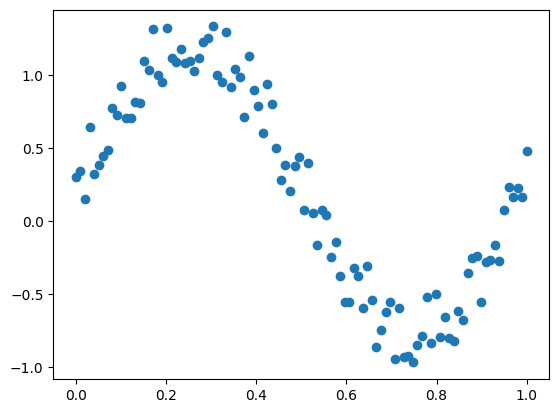

In [127]:
X_train = np.linspace(0,1,100).reshape(-1,1)
y_train = np.sin(2*np.pi*X_train).squeeze()
y_train = y_train + + 0.5*np.random.rand(len(y_train))

X_test = jnp.linspace(0,1,100).reshape(-1,1)
y_test = jnp.sin(2*jnp.pi*X_test).squeeze()
y_test = y_test + + 0.5*np.random.rand(len(y_test))

plt.scatter(X_train,y_train)

In [128]:
from functools import partial


In [169]:
M = 2  # Number of GPs
D = X_train.shape[1]



# Initial parameters: log(length_scale), log(variance), log(noise), log(weights)
init_params = jnp.log( jnp.concatenate(
(0.1*jnp.ones((D,)), 
 0.5*jnp.ones((D,)), 
 0.5*jnp.ones((M,)),
 0.01*jnp.ones((M,)),
 jnp.ones((M,))
 )
)
)  

# Define the optimizer
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(init_params)

# Define the update step
@partial(jax.jit, static_argnames=['M', 'D', 'normalize_weights'])
def update(params, opt_state, X, y, M, D,normalize_weights):
    loss, grads = value_and_grad(loo_cv_objective_jit)(params, X, y, M, D,normalize_weights)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 200
normalize_weights = True  # Set this flag to True if weights should sum to 1
for step in range(num_steps):
    loss, params, opt_state = update(params, opt_state, X_train, y_train, M, D,normalize_weights)
    if step % 100 == 0 or step == num_steps-1:
        print(f"Step {step}, Loss: {loss}")

# Get the optimized parameters
optimized_params = jnp.exp(params[:-M])  # Exclude weights from exponentiation
length_scales = optimized_params[:M * X_train.shape[1]].reshape((M, X_train.shape[1]))
variances = optimized_params[M * X_train.shape[1]:M * (X_train.shape[1] + 1)]
noises = optimized_params[M * (X_train.shape[1] + 1):M * (X_train.shape[1] + 2)]
weights = jnp.exp(params[-M:])  # Get the weights as they are (log transformation has already been applied)
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

Step 0, Loss: -115.29542584341118
Step 100, Loss: -139.6774585618083
Step 199, Loss: -140.1707445554385
Optimized Length Scales: [[0.23847206]
 [0.40372455]]
Optimized Variances: [0.23856768 1.28251515]
Optimized Noises: [0.01802478 0.02144723]
Optimized Weights: [0.1039861 0.8960139]


In [170]:
# Function to make predictions with the optimized GPs
def predict_gp(X_train, y_train, X_test, length_scales, variances, noises, weights):
    def gp_predict(length_scale, variance, noise):
        K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
        K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
        K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)
        
        K_chol = cho_factor(K, lower=True)[0]
        
        alpha = cho_solve((K_chol, True), y_train)
        v = cho_solve((K_chol, True), K_s.T)
        
        mu_s = K_s @ alpha
        cov_s = K_ss - K_s @ v
        
        return mu_s, jnp.diag(cov_s)
    
    mus, covs = vmap(gp_predict)(length_scales, variances, noises)
    
    weighted_vars_inv = weights[:, None] / covs
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * mus, axis=0)
    
    return fused_means, fused_vars


# Make predictions
mu_tst, var_tst = predict_gp(X_train, y_train, X_test, length_scales, variances, noises, weights)
mu_tr, var_tr = predict_gp(X_train, y_train, X_train, length_scales, variances, noises, weights)


In [171]:
print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-0.53175421]
NLPD Test:  [-0.40698407]
RMSE Train:  0.14169238017187372
RMSE Test:  0.16049389077210746


In [172]:
# Make predictions
mu_tst, var_tst = predict_gp(X_train, y_train, X_test, 
                             jnp.exp(init_params[:M * D].reshape(M,D)), 
                             jnp.exp(init_params[M * D : M * (D + 1)].reshape((M,))), 
                             jnp.exp(init_params[M * (D + 1):M * (D + 2)].reshape((M,))), 
                             jnp.exp(init_params[M * (D + 2):].reshape((M,))),
                             )
mu_tr, var_tr = predict_gp(X_train, y_train, X_train, jnp.exp(init_params[:M * D].reshape(M,D)), 
                             jnp.exp(init_params[M * D : M * (D + 1)].reshape((M,))), 
                             jnp.exp(init_params[M * (D + 1):M * (D + 2)].reshape((M,))), 
                             jnp.exp(init_params[M * (D + 2):].reshape((M,))),
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [0.17633359]
NLPD Test:  [0.61106939]
RMSE Train:  0.14211790550766043
RMSE Test:  0.15841227802681843


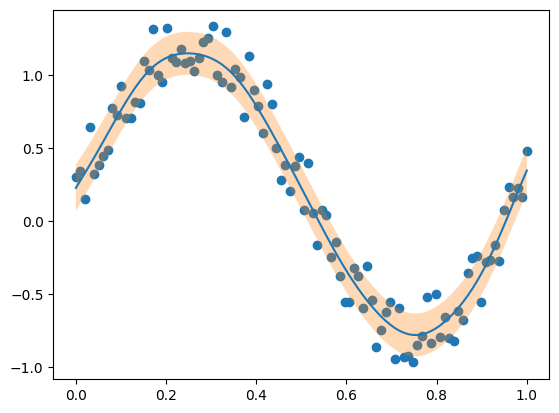

In [173]:
plt.scatter(X_train, y_train)
plt.plot(X_test,mu_tst)
plt.fill_between(X_test.squeeze(),mu_tst + 2*jnp.sqrt(var_tst),
                 mu_tst - 2*jnp.sqrt(var_tst), alpha=0.3)

## UCI dataset

In [174]:
from uci_datasets import Dataset
dataset_names = ["autos", 'housing','stock','sml',
                 'elevators','breastcancer','forest','gas',
                 ]


dataset_name = dataset_names[7]
full_dataset = Dataset(dataset_name)
N,DIM = full_dataset.x.shape

from sklearn.model_selection import train_test_split

X = full_dataset.x / np.std(full_dataset.x, axis=0)[None, :]
y = full_dataset.y / np.std(full_dataset.y, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# # load_data uses the normalized dataset, i.e., full_dataset.x and full_dataset.y have unit variance
# split = 0
# X_train,y_train,X_test,y_test,_ = load_data(dataset_name,split)

gas dataset, N=2565, d=128


In [175]:
np.std(X_train, axis=0)

array([1.00809721, 1.04479799, 1.00648584, 1.00372935, 1.03013427,
       1.00645023, 0.99106266, 1.0008858 , 1.00556992, 1.01259757,
       1.00341923, 1.0019854 , 1.00333223, 1.00438663, 1.01051998,
       1.01141934, 0.99880568, 0.98132366, 0.99361787, 1.03752346,
       1.05342631, 1.00110084, 1.01298642, 0.98978634, 0.99947687,
       0.99522348, 0.98773416, 0.94528674, 0.9796416 , 1.00659416,
       1.04580347, 1.04947355, 1.00004539, 1.05248982, 1.00034524,
       1.01722473, 1.04996699, 1.00834944, 1.04900376, 1.05273349,
       1.00009582, 1.05418339, 1.00023727, 1.01845495, 1.04991039,
       1.00146651, 1.03199244, 1.04981589, 0.99843369, 1.05415521,
       0.99809035, 0.99849151, 1.01937401, 0.99996809, 1.00452072,
       0.9835949 , 0.99826346, 1.05417688, 0.99818044, 0.99870065,
       1.01683153, 0.99981745, 1.00364234, 0.97541346, 1.00569334,
       1.00224999, 1.00481971, 1.00450076, 1.00404169, 1.00477939,
       1.00544521, 1.00737137, 1.00899557, 1.00420135, 1.00858

In [176]:
X_train = X_train[::3]
y_train = y_train[::3].squeeze()
y_test = y_test.squeeze()

In [177]:
X_train.shape, y_train.shape

((770, 128), (770,))

In [178]:
import tqdm
from functools import partial

In [179]:
M = 3  # Number of GPs
D = X_train.shape[1]

# Initial parameters: log(length_scale), log(variance), log(noise), log(weights)
# init_params = jnp.log(jnp.ones(M * (X_train.shape[1] + 2) + M))  # Adjust length to match X_train.shape[1] + 2 and include weights

# Initial parameters: log(length_scale), log(variance), log(noise), log(weights)
init_params = jnp.log( jnp.concatenate(
(0.1*jnp.ones((D,)), 0.5*jnp.ones((D,)), 1*jnp.ones((D,)),
 jnp.ones((M,)),
 0.2*jnp.ones((M,)),
 jnp.ones((M,)))
)
) 

# Define the optimizer
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(init_params)

# Define the update step
@partial(jax.jit, static_argnames=['M', 'D', 'normalize_weights'])
def update(params, opt_state, X, y, M, D,normalize_weights):
    loss, grads = value_and_grad(loo_cv_objective_jit)(params, X, y, M, D,normalize_weights)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 100
normalize_weights = True  # Set this flag to True if weights should sum to 1
for step in tqdm.tqdm(range(num_steps)):
    loss, params, opt_state = update(params, opt_state, X_train, y_train, M, D,normalize_weights)
    if step % 100 == 0 or step == num_steps-1:
        print(f"Step {step}, Loss: {loss}")

# Get the optimized parameters
optimized_params = jnp.exp(params[:-M])  # Exclude weights from exponentiation
length_scales = optimized_params[:M * X_train.shape[1]].reshape((M, X_train.shape[1]))
variances = optimized_params[M * X_train.shape[1]:M * (X_train.shape[1] + 1)]
noises = optimized_params[M * (X_train.shape[1] + 1):M * (X_train.shape[1] + 2)]
weights = jnp.exp(params[-M:])  # Get the weights as they are (log transformation has already been applied)
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

  1%|          | 1/100 [00:03<06:00,  3.65s/it]

Step 0, Loss: -3.9061420778865354


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]

Step 99, Loss: -1188.5910188174669
Optimized Length Scales: [[4.94753091e+02 3.41640543e+02 7.01261628e+02 6.46688518e+02
  4.44185296e+02 1.03774904e+03 1.20099903e+03 5.26558791e+02
  1.04194610e+00 1.31248226e+02 3.08698056e+01 1.15305523e+02
  1.05692500e+02 1.00549539e+01 1.96767024e+02 1.61967357e+02
  3.12084667e+02 2.34493113e+02 1.16849505e+02 7.00300633e+01
  5.45273419e-01 1.69303422e+02 1.53375996e+02 1.65644725e+02
  2.48470061e+02 2.05567943e+02 1.02496580e+02 9.85687506e+01
  1.55052633e+02 1.66127084e+02 1.64447290e+02 1.20479341e+02
  4.92797120e+01 1.53337997e+02 3.92666889e-01 4.87980245e+01
  6.27427865e+01 5.71376345e+01 1.40662256e+02 5.81484911e-01
  1.03660830e+02 1.06090612e+02 1.23009143e+02 9.75669848e+01
  5.78777001e+01 3.25841211e+01 1.08185868e+02 7.88352973e+01
  2.74745725e+02 2.38670861e+02 8.08543273e+01 8.01252531e+01
  9.43455848e+00 1.34983885e+02 1.66499993e+02 1.30866686e+02
  2.36305329e+02 2.06237688e+02 1.20680630e+02 9.99139676e+01
  6.153031

In [180]:
# Make predictions
mu_tst, var_tst = predict_gp(X_train, y_train, X_test, length_scales, variances, noises, weights)
mu_tr, var_tr = predict_gp(X_train, y_train, X_train, length_scales, variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


print("--------  Below, using initial parameter values -------")
# Make predictions
mu_tst, var_tst = predict_gp(X_train, y_train, X_test, 
                             jnp.exp(init_params[:M * D].reshape(M,D)), 
                             jnp.exp(init_params[M * D : M * (D + 1)].reshape((M,))), 
                             jnp.exp(init_params[M * (D + 1):M * (D + 2)].reshape((M,))), 
                             jnp.exp(init_params[M * (D + 2):].reshape((M,))),
                             )
mu_tr, var_tr = predict_gp(X_train, y_train, X_train, jnp.exp(init_params[:M * D].reshape(M,D)), 
                             jnp.exp(init_params[M * D : M * (D + 1)].reshape((M,))), 
                             jnp.exp(init_params[M * (D + 1):M * (D + 2)].reshape((M,))), 
                             jnp.exp(init_params[M * (D + 2):].reshape((M,))),
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))
print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-1.48349936]
NLPD Test:  [-0.63493929]
RMSE Train:  0.0371859323491938
RMSE Test:  0.21019968938578915
--------  Below, using initial parameter values -------
NLPD Train:  [-0.09793341]
NLPD Test:  [0.56501314]
RMSE Train:  0.12812436879292705
RMSE Test:  0.49844122084717923


## With projections

In [181]:
# LOO-CV objective function (negative log-score for minimization)
def loo_cv_objective(params, X, y, M,proj_dim, normalize_weights=False, proj_seed = 42):

    N,DIM = X.shape

    log_length_scales = lax.dynamic_slice(params, (0,), (M * proj_dim,)).reshape((M,proj_dim))
    log_variances = lax.dynamic_slice(params, (M * proj_dim,), (M,))
    log_noises = lax.dynamic_slice(params, (M * (proj_dim + 1),), (M,))
    log_weights = lax.dynamic_slice(params, (M * (proj_dim + 2),), (M,))
  
    length_scales, variances, noises = jnp.exp(log_length_scales), jnp.exp(log_variances), jnp.exp(log_noises)
    weights = jnp.exp(log_weights)


    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

    # ell = numpyro.sample("lengthscales", dist.HalfNormal(1.0))
    
    # X_projs = matmul_vmapped(X_reps, P_projs / ell[None, :, None])
    X_projs = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps, P_projs)
    # assert (ell[None, :, None] * P_projs).shape == P_projs.shape
    assert X_projs.shape == (M,N,proj_dim)

    
    if normalize_weights:
        weights = weights / jnp.sum(weights)
    
    def gp_loops(X,length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(X_projs,length_scales, variances, noises)
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)

    # print(fused_means.shape, fused_vars.shape)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization

# JIT compile the objective function for faster optimization
loo_cv_objective_with_projs_jit = jit(loo_cv_objective, static_argnames=['M','proj_dim',"normalize_weights"])


In [182]:
M=5
proj_dim = 10
init_params = jnp.log(jnp.concatenate(
    (0.5*jnp.ones((M * proj_dim,)),     # lengthscales
     1.0*jnp.ones((M,)),                # variances
     0.2*jnp.ones((M,)),                # noises
     jnp.ones((M,))),                   # weights
)
)  
loo_cv_objective_with_projs_jit(init_params,X_train,y_train,M,proj_dim,True)

Array(-2.22725274, dtype=float64)

In [183]:
# Define the optimizer
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(init_params)

# Define the update step
@partial(jax.jit, static_argnames=['M', 'proj_dim', 'normalize_weights'])
def update(params, opt_state, X, y, M, proj_dim,normalize_weights,proj_seed):
    loss, grads = value_and_grad(loo_cv_objective_with_projs_jit)(params, X, y, M, proj_dim,normalize_weights,proj_seed)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 250
normalize_weights = True  # Set this flag to True if weights should sum to 1
proj_seed = 2
losses = []

for step in range(num_steps):
    loss, params, opt_state = update(params, opt_state, X_train, y_train, M, proj_dim,normalize_weights,proj_seed)
    losses.append(loss)
    if step % 100 == 0 or step == num_steps-1:
        print(f"Step {step}, Loss: {loss}")

# Get the optimized parameters
optimized_params = jnp.exp(params[:-M])  # Exclude weights from exponentiation
length_scales = optimized_params[:M * proj_dim].reshape((M, proj_dim))
variances = optimized_params[M * proj_dim:M * (proj_dim + 1)]
noises = optimized_params[M * (proj_dim + 1):M * (proj_dim + 2)]
weights = jnp.exp(params[-M:])  # Get the weights as they are (log transformation has already been applied)
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

Step 0, Loss: -12.238713671430759
Step 100, Loss: -947.2343467817265
Step 200, Loss: -961.7509965168252
Step 249, Loss: -964.073372053248
Optimized Length Scales: [[416.5217133    1.40769285 192.2445083   16.40869889   9.31382568
    2.16427575 349.46506852  29.62107215  20.76622288 219.9376436 ]
 [  5.22439495   5.30001288   4.75766698   3.36374266   3.40322167
    2.90081164   3.98716388   4.67781814   2.16968025   4.18168578]
 [  7.42634735  33.0604159  222.32956686  43.74014448 129.78816394
    1.43334856   9.92452415  17.68376829  13.27235422  15.58423892]
 [ 36.39681443  16.89973978  11.32339986 136.35450204   5.99728179
    2.23311516   7.53930113  96.25084433  14.81404379   3.42608851]
 [  2.93631237   7.55389262   3.77554935   2.74697882   4.75924598
    7.50130886   4.54642338   4.12438779   6.3709929    0.94729674]]
Optimized Variances: [ 1.57553208  0.25867619 19.32779337  3.34217748  0.18951251]
Optimized Noises: [0.01422246 0.02675847 0.03375378 0.00871101 0.02639283]
Opt

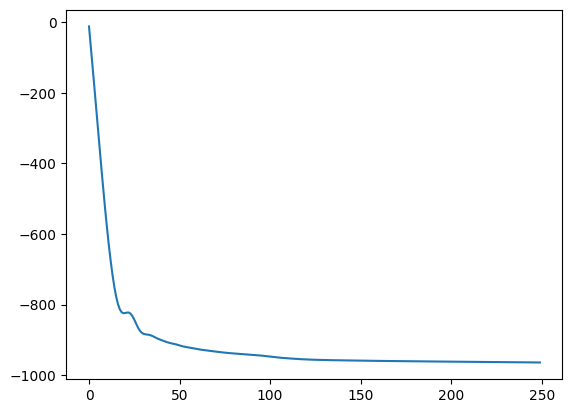

In [184]:
plt.plot(losses)

In [185]:
N,DIM = X_train.shape

X_reps = jnp.tile(jnp.expand_dims(X_train,0), (M,1,1))
X_reps_test = jnp.tile(jnp.expand_dims(X_test,0), (M,1,1))
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

# ell = numpyro.sample("lengthscales", dist.HalfNormal(1.0))

# X_projs = matmul_vmapped(X_reps, P_projs / ell[None, :, None])
X_projs = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps, P_projs)
X_projs_test = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps_test, P_projs)

In [186]:
X_projs.shape, X_projs_test.shape

((5, 770, 10), (5, 257, 10))

In [187]:
# Function to make predictions with the optimized GPs
def predict_gp_with_projs(X_train, y_train, X_test, length_scales, variances, noises, weights):
    def gp_predict(X_train,X_test,length_scale, variance, noise):
        K = kernel_matrix(X_train, X_train, length_scale, variance, noise)
        K_s = kernel_matrix(X_test, X_train, length_scale, variance, noise, include_noise=False)
        K_ss = kernel_matrix(X_test, X_test, length_scale, variance, noise)
        
        K_chol = cho_factor(K, lower=True)[0]
        
        alpha = cho_solve((K_chol, True), y_train)
        v = cho_solve((K_chol, True), K_s.T)
        
        mu_s = K_s @ alpha
        cov_s = K_ss - K_s @ v
        
        return mu_s, jnp.diag(cov_s)
    
    mus, covs = vmap(gp_predict)(X_train,X_test,length_scales, variances, noises)
    
    weighted_vars_inv = weights[:, None] / covs
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * mus, axis=0)
    
    return fused_means, fused_vars

In [188]:
# Make predictions
mu_tst, var_tst = predict_gp_with_projs(X_projs, y_train, X_projs_test, length_scales, variances, noises, weights)
mu_tr, var_tr = predict_gp_with_projs(X_projs, y_train, X_projs, length_scales, variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


print("--------  Below, using initial parameter values -------")
# Make predictions
mu_tst, var_tst = predict_gp_with_projs(X_projs, y_train, X_projs_test, 
                             jnp.exp(init_params[:M * proj_dim].reshape(M,proj_dim)), 
                             jnp.exp(init_params[M * proj_dim : M * (proj_dim + 1)].reshape((M,))), 
                             jnp.exp(init_params[M * (proj_dim + 1):M * (proj_dim + 2)].reshape((M,))), 
                             jnp.exp(init_params[M * (proj_dim + 2):].reshape((M,))),
                             )
mu_tr, var_tr = predict_gp_with_projs(X_projs, y_train, X_projs, 
                             jnp.exp(init_params[:M * proj_dim].reshape(M,proj_dim)), 
                             jnp.exp(init_params[M * proj_dim : M * (proj_dim + 1)].reshape((M,))), 
                             jnp.exp(init_params[M * (proj_dim + 1):M * (proj_dim + 2)].reshape((M,))), 
                             jnp.exp(init_params[M * (proj_dim + 2):].reshape((M,))),
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))
print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-0.48785519]
NLPD Test:  [-0.7103514]
RMSE Train:  0.13956573408474843
RMSE Test:  0.1623530495626072
--------  Below, using initial parameter values -------
NLPD Train:  [-0.28232846]
NLPD Test:  [0.5081966]
RMSE Train:  0.13701830436959364
RMSE Test:  0.5103817363795125


# With Pre-Projection Length scales

In [189]:
# LOO-CV objective function (negative log-score for minimization)
def loo_cv_objective(params, X, y, M,proj_dim, dim, normalize_weights=False, proj_seed = 42):

    N,DIM = X.shape

    log_length_scales = lax.dynamic_slice(params, (0,), (dim,)).reshape((dim))
    log_variances = lax.dynamic_slice(params, (dim,), (M,))
    log_noises = lax.dynamic_slice(params, (M + dim,), (M,))
    log_weights = lax.dynamic_slice(params, (M * 2 + dim,), (M,))
  
    length_scales, variances, noises = jnp.exp(log_length_scales), jnp.exp(log_variances), jnp.exp(log_noises)
    weights = jnp.exp(log_weights)


    X_reps = jnp.tile(jnp.expand_dims(X,0), (M,1,1))
    P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

    # ell = numpyro.sample("lengthscales", dist.HalfNormal(1.0))
    
    # X_projs = matmul_vmapped(X_reps, P_projs )
    X_projs = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps, P_projs/ length_scales[None, :, None])
    assert (length_scales[None, :, None] * P_projs).shape == P_projs.shape
    assert X_projs.shape == (M,N,proj_dim)

    
    if normalize_weights:
        weights = weights / jnp.sum(weights)
    
    def gp_loops(X,length_scale, variance, noise):
        K = kernel_matrix(X, X, length_scale, variance, noise)
        K_chol = cho_factor(K, lower=True)[0]
        alpha, diag_inv_K = compute_alpha_and_diag_inv_K(K_chol, y)
        
        loo_means = y - alpha / diag_inv_K
        loo_vars = 1 / diag_inv_K
        
        return loo_means, loo_vars
    
    loo_means, loo_vars = vmap(gp_loops)(X_projs, jnp.ones_like(variances), variances, noises)
    
    # Fuse the means and variances using the product rule with weights
    weighted_vars_inv = weights[:, None] / loo_vars
    fused_vars = 1 / jnp.sum(weighted_vars_inv, axis=0)
    fused_means = fused_vars * jnp.sum(weighted_vars_inv * loo_means, axis=0)

    # print(fused_means.shape, fused_vars.shape)
    
    # LOO predictive log-probability
    loo_cv_log_score = -0.5 * jnp.sum(jnp.log(fused_vars.squeeze()) + (y.squeeze() - fused_means.squeeze())**2 / fused_vars.squeeze())
    
    return -loo_cv_log_score  # Negative for minimization

# JIT compile the objective function for faster optimization
loo_cv_objective_with_projs_jit = jit(loo_cv_objective, static_argnames=['M','proj_dim',"dim","normalize_weights"])


In [195]:
M=5
proj_dim = 10
init_params = jnp.log(jnp.concatenate(
    (0.5*jnp.ones((X_train.shape[1],)),     # lengthscales
     1.0*jnp.ones((M,)),                # variances
     0.2*jnp.ones((M,)),                # noises
     jnp.ones((M,))),                   # weights
)
)  
loo_cv_objective_with_projs_jit(init_params,X_train,y_train,M,proj_dim,X_train.shape[1], False)

Array(-112.61193538, dtype=float64)

In [196]:
# Define the optimizer
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(init_params)

# Define the update step
@partial(jax.jit, static_argnames=['M', 'proj_dim', 'dim', 'normalize_weights'])
def update(params, opt_state, X, y, M, proj_dim, dim, normalize_weights,proj_seed):
    loss, grads = value_and_grad(loo_cv_objective_with_projs_jit)(params, X, y, M, proj_dim,dim,normalize_weights,proj_seed)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

# Training loop
params = init_params
num_steps = 250
normalize_weights = False  # Set this flag to True if weights should sum to 1
proj_seed = 2
dim = X_train.shape[1]
losses = []

for step in range(num_steps):
    loss, params, opt_state = update(params, opt_state, X_train, y_train, M, proj_dim,dim,normalize_weights,proj_seed)
    losses.append(loss)
    if step % 100 == 0 or step == num_steps-1:
        print(f"Step {step}, Loss: {loss}")

# Get the optimized parameters
optimized_params = jnp.exp(params[:-M])  # Exclude weights from exponentiation
length_scales = optimized_params[:dim]
variances = optimized_params[dim:dim+M]
noises = optimized_params[dim+M:dim+2*M]
weights = jnp.exp(params[-M:])  # Get the weights as they are (log transformation has already been applied)
if normalize_weights:
    weights = weights / jnp.sum(weights)

print("Optimized Length Scales:", length_scales)
print("Optimized Variances:", variances)
print("Optimized Noises:", noises)
print("Optimized Weights:", weights)

Step 0, Loss: -139.50692586050695
Step 100, Loss: -1347.604697390503
Step 200, Loss: -1838.8014299736299
Step 249, Loss: -1980.6804810374892
Optimized Length Scales: [4.57359016e+01 3.51250698e+02 1.09740457e+00 2.57723317e+00
 1.09355831e+02 4.97918387e+01 1.77114887e+02 3.49564015e+00
 3.51699309e+01 1.35718344e+01 2.64998357e+00 4.94885109e+00
 3.06303832e+00 4.17790545e+02 6.69168528e+01 2.47038891e+00
 8.92066798e+00 5.42268860e+00 4.65690886e-01 1.79093545e+00
 1.86528669e+02 1.26241241e+00 4.92388109e+00 1.65521430e+02
 2.28075434e+01 8.50384202e+00 5.50376716e+00 1.78487981e+00
 2.18441812e-01 1.69367941e+00 3.60547288e+00 4.27060833e-01
 8.27978266e-01 4.16710730e-01 1.04583942e+02 3.20938241e+00
 1.66113548e-01 1.45939242e+00 4.05493095e+01 6.97774267e+02
 1.62240591e-01 1.60450392e-02 1.18976718e+00 5.72875536e+02
 2.44837817e+02 1.32659549e+00 2.71250334e+01 2.53240865e+01
 8.46976910e+01 2.52574520e-02 2.95139225e+00 2.67038721e+00
 4.79755484e+02 2.32658916e+01 7.41150046

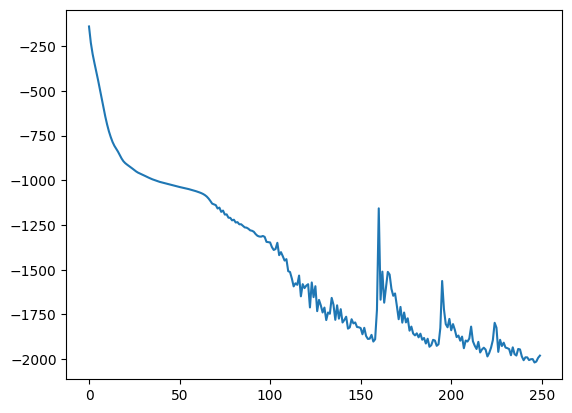

In [197]:
plt.plot(losses)

In [198]:
N,DIM = X_train.shape

X_reps = jnp.tile(jnp.expand_dims(X_train,0), (M,1,1))
X_reps_test = jnp.tile(jnp.expand_dims(X_test,0), (M,1,1))
P_projs = jax.random.normal(jax.random.PRNGKey(proj_seed), (M,DIM, proj_dim))/jnp.sqrt(proj_dim)   

# ell = numpyro.sample("lengthscales", dist.HalfNormal(1.0))

# X_projs = matmul_vmapped(X_reps, P_projs / ell[None, :, None])
    # X_projs = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps, P_projs/ length_scales[None, :, None])

X_projs = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps, P_projs/ length_scales[None, :, None])
X_projs_test = jax.vmap(lambda A,B: (A @ B).squeeze(), in_axes=(0, 0))(X_reps_test, P_projs/ length_scales[None, :, None])

In [199]:
# Make predictions
mu_tst, var_tst = predict_gp_with_projs(X_projs, y_train, X_projs_test, jnp.ones_like(variances), variances, noises, weights)
mu_tr, var_tr = predict_gp_with_projs(X_projs, y_train, X_projs, jnp.ones_like(variances), variances, noises, weights)

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))

print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))


print("--------  Below, using initial parameter values -------")
# Make predictions
mu_tst, var_tst = predict_gp_with_projs(X_projs, y_train, X_projs_test, 
                             jnp.ones_like(variances),#jnp.ones((M, proj_dim)), 
                             jnp.exp(init_params[dim:dim+M].reshape((M,))), 
                             jnp.exp(init_params[dim+M:dim+2*M].reshape((M,))), 
                             jnp.exp(init_params[dim+2*M:].reshape((M,))),
                             )
mu_tr, var_tr = predict_gp_with_projs(X_projs, y_train, X_projs, 
                             jnp.ones_like(variances),#jnp.ones((M, proj_dim)), 
                             jnp.exp(init_params[dim:dim+M].reshape((M,))), 
                             jnp.exp(init_params[dim+M:dim+2*M].reshape((M,))), 
                             jnp.exp(init_params[dim+2*M:].reshape((M,))),
                             )

print("NLPD Train: ", compute_neg_log_like(mus=mu_tr,stds=jnp.sqrt(var_tr),y_test=y_train))
print("NLPD Test: ",  compute_neg_log_like(mus=mu_tst,stds=jnp.sqrt(var_tst),y_test=y_test))
print("RMSE Train: ", jnp.sqrt( jnp.mean( (mu_tr.squeeze() - y_train.squeeze())**2 ) ))
print("RMSE Test: ", jnp.sqrt( jnp.mean( (mu_tst.squeeze() - y_test.squeeze())**2 ) ))

NLPD Train:  [-5.85930921]
NLPD Test:  [95.03119811]
RMSE Train:  6.315705123182933e-05
RMSE Test:  0.23840255753324063
--------  Below, using initial parameter values -------
NLPD Train:  [-0.38575153]
NLPD Test:  [-0.23131972]
RMSE Train:  0.12145892203543718
RMSE Test:  0.25000620193310014
